### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
from natsort import natsorted
from scipy.signal import argrelextrema
import statistics
from scipy.stats import skew
from itertools import chain
from itertools import groupby
import pubchempy as pcp
import math
import requests
import similaritymeasures as sm
from tqdm import tqdm

### Importing Data from PROMIS experiments

In [2]:
#Set initial variables for importing proteomics and metabolomics data
plant_names = ['P8', 'P12', 'P15', 'P25', 'P33', 'P45', 'P60', 'P68', 'P71', 'P75', 'P99', 'P101', 'P102', 'P107','P113', 'P116', 'P118', 'P125', 'P126', 'P132', 'P133', 'P136', 'P140', 'P349','P473','P477', 'Control2']

n_fracs = [40,54,43,57,43,40,52,44,45,39,57,43,43,39,44,80,50,41,49,43,41,38,41,47,46,47,40]

dfp = {}
dfm = {}
fixed_dfm = {}
unique_dfp = {}

In [3]:
print(len(n_fracs), len(plant_names))

27 27


In [4]:
frac =[]
plant_list = []
#first let's get the protein curves for all plants
for i,plant in enumerate(plant_names):
    #Import raw protein data
    #cvl_map = pd.read_csv(os.path.join('data','plate_cvl_mapping.csv'),index_col=0)
    cvl_map = pd.read_csv(os.path.join('D:/PROMISed_Data','plate_cvl_mapping.csv'),index_col=0)
    cvl_map = cvl_map.loc[cvl_map.plant== plant]
    #proteomics_path = './data/' + plant + '/Fragpipe_' + plant + '(R)/'
    proteomics_path = 'D:/PROMISed_Data/' + plant + '/Fragpipe_' + plant + '(R)/'
    protein_raw_df = pd.read_csv(os.path.join(proteomics_path,'combined_protein.tsv'),sep='\t')

   #filter
    protein_raw_df = protein_raw_df[protein_raw_df["Protein ID"].str.contains("contam_sp") == False]
    protein_raw_df = protein_raw_df[protein_raw_df["Description"].str.contains("Keratin") == False]
    protein_raw_df = protein_raw_df[protein_raw_df["Combined Unique Spectral Count"] >= 2]
   
    
    #Get number of unique peptides
    for exp in [f for f in os.listdir(proteomics_path) if f[:3]=='exp']:
        frac_df = pd.read_csv(os.path.join(proteomics_path,exp,'protein.tsv'),sep='\t')
        protein_raw_df = pd.merge(protein_raw_df,frac_df[['Protein ID','Unique Peptides']],how='left',on='Protein ID')
        protein_raw_df = protein_raw_df.rename(columns={'Unique Peptides':f'{exp}_upeps'})
    protein_df = protein_raw_df.copy()
    #print('protein_df= ' +str(protein_df.shape))

    #Get column names for the protein data frame
    exp_cvl = {r[1]['exp']+' Unique Intensity':
           r[1]['fraction'] for r in cvl_map.iterrows()}
    
    # we only want to keep the id column, abundance columns (Unique Intensity)
    abundance_cols = [e for e in exp_cvl.keys()]
    protein_df = protein_raw_df[['Protein ID']+abundance_cols].set_index('Protein ID')
    protein_df = protein_df.rename(columns=exp_cvl)
    dfp[plant] = protein_df.copy()
    print(str(plant)+ ': dfp ' +"= "+str(dfp[plant].shape))
    
    pl = plant
    plant_list.append(pl)
    f = dfp[plant].shape[1]
    frac.append(f)
frac_dict = dict(zip(plant_list, frac))


P8: dfp = (2205, 40)
P12: dfp = (2107, 54)
P15: dfp = (3302, 43)
P25: dfp = (2998, 57)
P33: dfp = (3102, 43)
P45: dfp = (2464, 40)
P60: dfp = (2743, 52)
P68: dfp = (2957, 44)
P71: dfp = (3138, 45)
P75: dfp = (2984, 39)
P99: dfp = (2419, 57)
P101: dfp = (3212, 43)
P102: dfp = (2407, 43)
P107: dfp = (3263, 39)
P113: dfp = (2926, 44)
P116: dfp = (2820, 80)
P118: dfp = (3864, 50)
P125: dfp = (2471, 41)
P126: dfp = (3709, 49)
P132: dfp = (3368, 43)
P133: dfp = (4167, 41)
P136: dfp = (2573, 38)
P140: dfp = (3208, 41)
P349: dfp = (2908, 47)
P473: dfp = (3028, 46)
P477: dfp = (3486, 47)
Control2: dfp = (2953, 40)


In [5]:
# now let's get the metabolite curves
for i,plant in tqdm(enumerate(plant_names)):
    #Import raw metabolite data (these data are uploded in the S3 Browser /enveda-data-raw/lcms/kundan/PROMISed_data)
    cvl_map = pd.read_csv(os.path.join('D:/PROMISed_Data','plate_cvl_mapping.csv'),index_col=0)
    cvl_map = cvl_map.loc[cvl_map.plant== plant]
    #metabol_raw_df = pd.read_csv("./data/" + plant +  "/metabolomics/Height_0_2022.txt", sep='\t',skiprows=4)
    metabol_raw_df = pd.read_csv("D:/PROMISed_Data/" + plant +  "/metabolomics/Area.txt", sep='\t',skiprows=4)
    metabol_raw_df = metabol_raw_df.loc[metabol_raw_df['MS/MS assigned'] == True]
    metabol_df = metabol_raw_df.copy()

    #Reformat metabol_df data frame
    #We only keep the abundance columns and the Metabolites column
    abundance_cols_map = {r[1]['meta_cvl'] +'_P':r[1]['fraction'] for r in cvl_map.iterrows()}
    metabol_df['Metabolites']= metabol_df[['Alignment ID','Average Rt(min)','Average Mz']].apply(
                            lambda x: '_'.join([str(int(x.iloc[0])),str(x.iloc[1]),str(x.iloc[2])]),axis=1)

#    metabol_df_spec = metabol_df.set_index_('Alignment ID')
    metabol_df = metabol_df[['Metabolites']+list(abundance_cols_map.keys())].set_index('Metabolites')
    metabol_df = metabol_df.rename(columns=abundance_cols_map)
    
    dfm[plant] = metabol_df.copy()
    #print(str(plant)+ ': dfm = '+str(dfm[plant].shape))

27it [02:56,  6.54s/it]


In [6]:
print(dfp[plant].shape, dfm[plant].shape)

(2953, 40) (6001, 40)


In [7]:
#Create mapping from columns to cvl mapping
all_fracs = ['P{0}_{1}{2}'.format(x,y,z) for x in [1,2] for y in ['A','B','C','D','E'] for z in list(range(1,9))]
all_fracs = {v:i for i, v in enumerate(all_fracs)}

def get_frac_vector(row, fracs_map):
    # row is a series (index are the plate fractions)
    # fracs_map is a dict whose keys are the fraction names e.g. Pt1_A8 and values are integers (0-79)
    # return a ndarray
    vec = np.zeros(len(fracs_map))
    blanks = -1*np.ones(len(fracs_map))
    for v in row.index:
        vec[fracs_map[v]] = row[v]
        blanks[fracs_map[v]] = 0
    if all(x == 0 for x in vec):
        return vec, blanks
    else:
        #return vec/vec.max(), blanks
        return vec, blanks

In [8]:
dfp_80 = {}
dfm_80 = {}
all_blanks = []

for plant in tqdm(plant_names):
    #Set initial variables
    corrected_fractions = np.zeros((dfp[plant].shape[0], len(all_fracs)))
    protein_names = dfp[plant].index.values

    #Get 80 fractions for each protein
    for i,protein in enumerate(protein_names):
        corrected_fractions[i,:] = get_frac_vector(dfp[plant].loc[protein], all_fracs)[0]

    #Create new protein data frame with 80 fractions
    blanks = get_frac_vector(dfp[plant].loc[protein], all_fracs)[1]
    dfp_80[plant] = pd.DataFrame(corrected_fractions)
    dfp_80[plant]['Protein ID'] = protein_names
    dfp_80[plant] = dfp_80[plant].set_index('Protein ID')

    #Set initial variables
    corrected_fractions = np.zeros((dfm[plant].shape[0], len(all_fracs)))
    metabol_names = dfm[plant].index.values

    #Get 80 fractions for each metabolite
    for i,metabol in enumerate(metabol_names):
        corrected_fractions[i,:] = get_frac_vector(dfm[plant].loc[metabol], all_fracs)[0]
    
    #Create new metabolite data frame with 80 fractions
    dfm_80[plant] = pd.DataFrame(corrected_fractions)
    dfm_80[plant]['Metabolite ID'] = metabol_names
    dfm_80[plant] = dfm_80[plant].set_index('Metabolite ID')
    all_blanks.append(blanks)
    
#dfp_80['Control'] = control_dfp.copy()

#Get protein IDs
protein_names = []
for i,plant in enumerate(plant_names):
    protein_names.append(list(dfp[plant].loc[~(dfp[plant] == 0).all(axis=1)].index.values))

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:26<00:00,  7.66s/it]


In [9]:
for plant in plant_names:
    print(plant, dfp_80[plant].shape)

P8 (2205, 80)
P12 (2107, 80)
P15 (3302, 80)
P25 (2998, 80)
P33 (3102, 80)
P45 (2464, 80)
P60 (2743, 80)
P68 (2957, 80)
P71 (3138, 80)
P75 (2984, 80)
P99 (2419, 80)
P101 (3212, 80)
P102 (2407, 80)
P107 (3263, 80)
P113 (2926, 80)
P116 (2820, 80)
P118 (3864, 80)
P125 (2471, 80)
P126 (3709, 80)
P132 (3368, 80)
P133 (4167, 80)
P136 (2573, 80)
P140 (3208, 80)
P349 (2908, 80)
P473 (3028, 80)
P477 (3486, 80)
Control2 (2953, 80)


In [10]:
protein_db = pd.read_csv('all_proteomics_db_new.tsv', sep = "\t")

In [11]:
protein_db = protein_db.iloc[:,1:]

In [12]:
protein_db.head(2)

,Uniprot_ID,Protein_name,Gene_name,Organism_name,Experiment,Study
0,A2AJL3,FGGY carbohydrate kinase domain-containing pro...,Fggy,Mouse,CDAA_NASH,LipQuant
1,A2AS89,"Agmatinase, mitochondrial",Agmat,Mouse,CDAA_NASH,LipQuant


In [13]:
protein_db.shape

(125508, 6)

In [14]:
protein_list = ['Ubr4', 'Rnf114']
protein_list = list(map(str.lower,protein_list))
selected_protein_db = protein_db[protein_db['Gene_name'].str.lower().isin(protein_list)]
selected_protein_db = selected_protein_db[selected_protein_db['Study'] == 'PROMIS']

selected_protein_db_in_plant = selected_protein_db[selected_protein_db['Experiment'].isin(plant_names)]
selected_protein_db_control = selected_protein_db[selected_protein_db['Experiment'] == 'Control2']

plant_Uniprot_ID_list = list(selected_protein_db_in_plant['Uniprot_ID'])
control_Uniprot_ID_list = list(selected_protein_db_control['Uniprot_ID'])

In [15]:
plant_only = ['P8', 'P12', 'P33', 'P45', 'P60', 'P68', 'P71', 'P75', 'P99', 'P101', 'P102', 'P107', 'P116', 'P118', 'P125', 'P126', 'P132', 'P133', 'P136', 'P140', 'P349','P473','P477']
control_data = ['Control2']

In [16]:
# excluded plant (P116, P125 for Ubr4) and (P116 for rnf) as they are not in stable fraction
plant_names_ubr4 = ['P140', 'P102', 'P136', 'P15', 'P99', 'P126', 'P33', 'P477', 'P133', 'P113', 'P75', 'P132', 'P45', 'P101', 'P25', 'P60', 'P118']
plant_names_rnf = ['P140', 'P349', 'P473', 'P136', 'P15', 'P99', 'P33', 'P477', 'P133', 'P75', 'P132', 'P45', 'P101', 'P68', 'P60', 'P118', 'P107']

In [17]:
print(len(plant_names_ubr4), len(plant_names_rnf))

17 17


* <b>Analysis strats from here</b> 

### 1st part (in which fraction Ubr4/Rnf114 is present in different plant)

#### Ubr4

In [395]:
## in which fraction Ubr4 is present in different plant
for plant in plant_names:
    cdf = dfp_80[plant]
    if 'A2AN08' in cdf.index:
        ndf = cdf.loc[['A2AN08']]
        
        header = []
        for i in range(len(ndf.columns)):
            header.append(i+1)
        ndf.columns=header
        
        columns = (ndf != 0).any()
        columns_list = columns.index[columns].tolist()
        #columns = (x != 0).any()
        if len(columns_list) >0:
            print(plant, columns_list)
    else:
        continue

P15 [7, 8, 9, 11, 12, 13, 35]
P25 [8, 9, 10, 11, 13, 21]
P33 [6, 7, 8, 9, 10, 11]
P45 [7, 9, 10]
P60 [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
P75 [7, 8, 10, 11]
P99 [5, 6, 7, 8, 9, 11]
P101 [7, 8, 9, 10, 11, 12, 13]
P102 [7, 10]
P113 [16, 17, 18, 19, 42]
P116 [2, 3, 4, 5, 6, 8, 9]
P118 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
P125 [34, 36, 37]
P126 [6, 7, 8, 11, 12, 13]
P132 [7, 8, 9, 10, 11, 12, 13, 14, 21, 23, 26, 29]
P133 [6, 8, 9, 11, 12]
P136 [8, 10, 11, 12]
P140 [7, 8, 9, 10, 11, 12, 13, 14]
P477 [7, 8, 9, 10, 11, 12, 13]


In [396]:
#list get all rows that have proteins across the plants which is **stable in 7-13th column** and save them in restpective dataframe
dfp_80_baseline_ubr4 = {}

for plant in plant_names_ubr4:
    current_df = dfp_80[plant]
    base_line = pd.DataFrame([])
    #print(plant , current_df.shape)
    for val in range(0,len(current_df)):
        l = list(current_df.iloc[val])
        #size = len(l)
        if plant == 'P15' and l[6] >0 and l[7] >0 and l[8] >0 and l[9] ==0 and l[10] >0 and l[11] >0 and l[12] >0:
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P25' and (l[6] ==0 and l[7] >0 and l[8] >0 and l[9] >0 and l[10] >0 and l[11] ==0 and l[12] >0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P33' and (l[6] >0 and l[7] >0 and l[8] >0 and l[9] >0 and l[10] >0 and l[11] ==0 and l[12] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P45' and (l[6] >0 and l[7] ==0 and l[8] >0 and l[9] >0 and l[10] ==0 and l[11] ==0 and l[12] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P60' and (l[6] >0 and l[7] >0 and l[8] >0 and l[9] >0 and l[10] >0 and l[11] >0 and l[12] >0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P75' and (l[6] >0 and l[7] >0 and l[8] ==0 and l[9] >0 and l[10] >0 and l[11] ==0 and l[12] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P99' and (l[6] >0 and l[7] >0 and l[8] >0 and l[9] ==0 and l[10] >0 and l[11] ==0 and l[12] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P101' and (l[6] >0 and l[7] >0 and l[8] >0 and l[9] >0 and l[10] >0 and l[11] >0 and l[12] >0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P102' and (l[6] >0 and l[7] ==0 and l[8] ==0 and l[9] >0 and l[10] ==0 and l[11] ==0 and l[12] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P113' and (l[6] ==0 and l[7] ==0 and l[8] ==0 and l[9] ==0 and l[10] ==0 and l[11] ==0 and l[12]) ==0:
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P116' and (l[6] ==0 and l[7] >0 and l[8] >0 and l[9] ==0 and l[10] ==0 and l[11] ==0 and l[12] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P118' and (l[6] >0 and l[7] >0 and l[8] >0 and l[9] >0 and l[10] >0 and l[11] >0 and l[12] >0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P125' and (l[6] ==0 and l[7] ==0 and l[8] ==0 and l[9] ==0 and l[10] ==0 and l[11] ==0 and l[12] ==0):
            base_line = base_line.append(current_df.iloc[val])
        
        if plant == 'P126' and (l[6] >0 and l[7] >0 and l[8] ==0 and l[9] ==0 and l[10] >0 and l[11] >0 and l[12] >0):
            base_line = base_line.append(current_df.iloc[val])

        if plant == 'P132' and (l[6] >0 and l[7] >0 and l[8] >0 and l[9] >0 and l[10] >0 and l[11] >0 and l[12] >0):
            base_line = base_line.append(current_df.iloc[val])

        if plant == 'P133' and (l[6] ==0 and l[7] >0 and l[8] >0 and l[9] ==0 and l[10] >0 and l[11] >0 and l[12] ==0):
            base_line = base_line.append(current_df.iloc[val])

        if plant == 'P136' and (l[6] ==0 and l[7] >0 and l[8] ==0 and l[9] >0 and l[10] >0 and l[11] >0 and l[12] ==0):
            base_line = base_line.append(current_df.iloc[val])

        if plant == 'P140' and (l[6] >0 and l[7] >0 and l[8] >0 and l[9] >0 and l[10] >0 and l[11] >0 and l[12] >0):
            base_line = base_line.append(current_df.iloc[val])

        if plant == 'P477' and (l[6] >0 and l[7] >0 and l[8] >0 and l[9] >0 and l[10] >0 and l[11] >0 and l[12] >0):
            base_line = base_line.append(current_df.iloc[val])
            
            
        else:
            continue
    dfp_80_baseline_ubr4[plant] = base_line.copy()
    print(plant, dfp_80_baseline_ubr4[plant].shape)



P140 (383, 80)
P102 (5, 80)
P136 (2, 80)
P15 (62, 80)
P99 (9, 80)
P126 (411, 80)
P33 (78, 80)
P477 (528, 80)
P133 (244, 80)
P113 (2800, 80)
P75 (5, 80)
P132 (526, 80)
P45 (10, 80)
P101 (443, 80)
P25 (460, 80)
P60 (519, 80)
P118 (726, 80)


##### check

In [397]:
#check ok

#for plant in plant_names_ubr4:
#    if 'A2AN08' in dfp_80_baseline_ubr4[plant].index:
#        print('true')
#    else:
#        print('false')

In [398]:
#check ok

#for plant in plant_names_ubr4:
#    tdf = dfp_80[plant]
#    if 'A2AN08' in tdf.index:
#        ndf = tdf.loc[['A2AN08']]
#        ndf.T.plot()   

##### output

In [399]:
#list all the proteins across the plants which is *** stable in 6-12th column ***
ubr4_stable = []
for plant in plant_names_ubr4:
    lst= list(dfp_80_baseline_ubr4[plant].index)
    ubr4_stable.extend(lst)

ubr4_stable = set(ubr4_stable)
len(ubr4_stable)

2931

In [400]:
with open('revised_ubr4_stable.txt', 'w') as f:
    for i in ubr4_stable:
        f.writelines(i+'\n')

#### Rnf114

In [401]:
## in which fraction Rnf114 is present in different plant
for plant in plant_names:
    cdf = dfp_80[plant]
    if 'Q9ET26' in cdf.index:
        ndf = cdf.loc[['Q9ET26']]
        
        header = []
        for i in range(len(ndf.columns)):
            header.append(i+1)
        ndf.columns=header
        
        columns = (ndf != 0).any()
        columns_list = columns.index[columns].tolist()
        #columns = (x != 0).any()
        if len(columns_list) >0:
            print(plant, columns_list)
    else:
        continue

P15 [33, 36, 37, 38, 45]
P33 [34, 35, 36, 37, 38]
P45 [8, 10, 12, 13, 16, 17, 18, 19, 21, 33, 36]
P60 [33, 34, 35, 36, 37]
P68 [6, 31, 35, 36, 37, 38, 39, 40, 43, 52]
P75 [36, 37]
P99 [34, 37]
P101 [26, 33, 34, 35, 36, 37]
P107 [36, 37, 38]
P116 [8, 10]
P118 [33, 35, 36, 37, 38, 39, 40]
P132 [34, 35, 37, 38]
P133 [8, 11, 13, 16, 34, 35, 36, 38, 39, 40, 41, 43, 45]
P136 [35, 36, 37, 38]
P140 [34, 35, 36, 37, 38]
P349 [35, 36]
P473 [34, 35, 37, 39]
P477 [34, 37, 38]
Control2 [34, 35, 37, 38]


In [402]:
#list get all rows that have proteins across the plants which is ** stable in 32-37th column ** and save them in restpective dataframe
dfp_80_baseline_rnf = {}

for plant in plant_names_rnf:
    current_df = dfp_80[plant]
    base_line = pd.DataFrame([])
    #print(plant , current_df.shape)
    for val in range(0,len(current_df)):
        l = list(current_df.iloc[val])
        #size = len(l)
        if plant == 'P15' and (l[32] >0 and l[33] ==0 and l[34] ==0 and l[35] >0 and l[36] >0 and l[37] >0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P33' and (l[32] ==0 and l[33] >0 and l[34] >0 and l[35] >0 and l[36] >0 and l[37] >0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P45' and (l[32] >0 and l[33] ==0 and l[34] ==0 and l[35] >0 and l[36] ==0 and l[37] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P60' and (l[32] >0 and l[33] >0 and l[34] >0 and l[35] >0 and l[36] >0 and l[37] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P68' and (l[32] ==0 and l[33] ==0 and l[34] >0 and l[35] >0 and l[36] >0 and l[37] >0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P75' and (l[32] ==0 and l[33] ==0 and l[34] ==0 and l[35] >0 and l[36] >0 and l[37] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P99' and (l[32] ==0 and l[33] >0 and l[34] ==0 and l[35] ==0 and l[36] >0 and l[37] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P101' and (l[32] >0 and l[33] >0 and l[34] >0 and l[35] >0 and l[36] >0 and l[37] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P107' and (l[32] ==0 and l[33] ==0 and l[34] ==0 and l[35] >0 and l[36] >0 and l[37] >0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P116' and (l[32] ==0 and l[33] ==0 and l[34] ==0 and l[35] ==0 and l[36] ==0 and l[37] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P118' and (l[32] >0 and l[33] ==0 and l[34] >0 and l[35] >0 and l[36] >0 and l[37] >0):
            base_line = base_line.append(current_df.iloc[val])

        if plant == 'P132' and (l[32] ==0 and l[33] >0 and l[34] >0 and l[35] ==0 and l[36] >0 and l[37] >0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P133' and (l[32] ==0 and l[33] >0 and l[34] >0 and l[35] >0 and l[36] ==0 and l[37] >0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P136' and (l[32] ==0 and l[33] ==0 and l[34] >0 and l[35] >0 and l[36] >0 and l[37] >0):
            base_line = base_line.append(current_df.iloc[val])

        if plant == 'P140' and (l[32] ==0 and l[33] >0 and l[34] >0 and l[35] >0 and l[36] >0 and l[37] >0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P349' and (l[32] ==0 and l[33] ==0 and l[34] >0 and l[35] >0 and l[36] ==0 and l[37] ==0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P473' and (l[32] ==0 and l[33] >0 and l[34] >0 and l[35] ==0 and l[36] >0 and l[37] >0):
            base_line = base_line.append(current_df.iloc[val])
            
        if plant == 'P477' and (l[32] ==0 and l[33] >0 and l[34] ==0 and l[35] ==0 and l[36] >0 and l[37] >0):
            base_line = base_line.append(current_df.iloc[val])           
            
        else:
            continue
    dfp_80_baseline_rnf[plant] = base_line.copy()
    print(plant, dfp_80_baseline_rnf[plant].shape)



P140 (42, 80)
P349 (1, 80)
P473 (2, 80)
P136 (42, 80)
P15 (5, 80)
P99 (13, 80)
P33 (36, 80)
P477 (1, 80)
P133 (4, 80)
P75 (11, 80)
P132 (9, 80)
P45 (4, 80)
P101 (99, 80)
P68 (64, 80)
P60 (30, 80)
P118 (10, 80)
P107 (54, 80)


##### check

In [403]:
#check ok
#for plant in plant_names_rnf:
#    if 'Q9ET26' in dfp_80_baseline_rnf[plant].index:
#        print('true')
#    else:
#        print('false')

In [404]:
#check ok

#for plant in plant_names_ubr4:
#    tdf = dfp_80[plant]
#    if 'Q9ET26' in tdf.index:
#        ndf = tdf.loc[['Q9ET26']]
#        ndf.T.plot()   

##### output

In [405]:
#list all the proteins across the plants which is *** stable in 32-30th column ***
rnf_stable = []
for plant in plant_names_rnf:
    lst= list(dfp_80_baseline_rnf[plant].index)
    rnf_stable.extend(lst)

rnf_stable = set(rnf_stable)
len(rnf_stable)

316

In [406]:
with open('revised_rnf_stable.txt', 'w') as f:
    for i in rnf_stable:
        f.writelines(i+'\n')

#### Control

In [407]:
# column for elutions of Ubr4 and rnf114 in the cotrol data
for gene in ['A2AN08', 'Q9ET26']:
    x = dfp_80['Control2'].loc[[gene]]
    
    header = []
    for i in range(len(x.columns)):
        header.append(i+1)
    x.columns=header
    
    columns = (x != 0).any()
    columns_list = columns.index[columns].tolist()
    print(gene, columns_list)


A2AN08 []
Q9ET26 [34, 35, 37, 38]


In [408]:
dfp_80['Control2'].loc[['Q9ET26']].iloc[:,30:40]

,30,31,32,33,34,35,36,37,38,39
Protein ID,,,,,,,,,,
Q9ET26,0.0,0.0,0.0,37085448.0,26902316.0,0.0,85466280.0,87729416.0,0.0,0.0


In [409]:
#get all rows that have proteins across the plants which is ** stable ** in the column in which ubr4 and rnf114 is eluting in the control data

dfp_80_baseline_control = {}

for plant in control_data:
    current_df = dfp_80[plant]
    rnf_base_line_in_control = pd.DataFrame([])
    for val in range(0,len(current_df)):
        l = list(current_df.iloc[val])
        #size = len(l)
        #if l[33] >0 and l[34] >0 and l[35] ==0 and l[36] >0 and l[37] >0: OR
        if all(item > 0 for item in l[33:35]) and l[35] ==0 and all(item > 0 for item in l[36:38]):
            rnf_base_line_in_control = rnf_base_line_in_control.append(current_df.iloc[val])
        else:
            continue
    dfp_80_baseline_control[plant] = rnf_base_line_in_control.copy()

print(rnf_base_line_in_control.shape)
print(dfp_80_baseline_control[plant].shape)



(10, 80)
(10, 80)


##### check

In [410]:
#check ok
#for plant in plant_names_rnf:
#    if 'Q9ET26' in dfp_80_baseline_control['Control2'].index:
#        print('true')
#    else:
#        print('false')

In [411]:
#check ok

#for plant in control_data:
#    tdf = dfp_80[plant]
#    if 'Q9ET26' in tdf.index:
#        ndf = tdf.loc[['Q9ET26']]
#        ndf.T.plot()  

##### output

In [412]:
#list all the proteins in the control data which is stable with rnf in different column
rnf_stable_in_control = []

rnf_stable_in_control = list(rnf_base_line_in_control.index)

rnf_stable_in_control = set(rnf_stable_in_control)

len(rnf_stable_in_control)

10

In [413]:
with open('revised_rnf_stable_in_control.txt', 'w') as f:
    for i in rnf_stable_in_control:
        f.writelines(i+'\n')

### 2nd part

In [414]:
# Compile list of all proteins that are present in plants P133, P116, P45, P101 (where Rnf114, UBR4 fractions have moved/appear,
# 2A) and NOT in Control  Lysate (where RNf114, Ubr4; 2B). Subtracted list 2A- (1+2B) = 2C (your output list of proteins).
#Output 0

##### ubr4

In [415]:
## in which fraction ubr4 is present in moving plant
for plant in ['P116', 'P125', 'P126', 'P132', 'P133']:
    cdf = dfp_80[plant]
    if 'A2AN08' in cdf.index:
        ndf = cdf.loc[['A2AN08']]
        
#        header = []
#        for i in range(len(ndf.columns)):
#            header.append(i+1)
#        ndf.columns=header
        
        columns = (ndf != 0).any()
        columns_list = columns.index[columns].tolist()
        #columns = (x != 0).any()
        if len(columns_list) >0:
            print(plant, columns_list)
    else:
        continue

P116 [1, 2, 3, 4, 5, 7, 8]
P125 [33, 35, 36]
P126 [5, 6, 7, 10, 11, 12]
P132 [6, 7, 8, 9, 10, 11, 12, 13, 20, 22, 25, 28]
P133 [5, 7, 8, 10, 11]


In [549]:
## moved in with ubr4, present in ** moved ** fractions

dfp_80_moved_ubr4 = {}

for plant in ['P116', 'P125', 'P126', 'P132', 'P133']:
    current_df = dfp_80[plant]
    moved_protein = pd.DataFrame([])
    #print(plant , current_df.shape)
    for val in range(0,len(current_df)):
        l = list(current_df.iloc[val])
        #size = len(l)
        #if plant == 'P116' and l[0] ==0 and all(item > 0 for item in l[1:6]) and l[6] ==0 and all(item > 0 for item in l[7:9]) and all(item == 0 for item in l[9:80]):
        if plant == 'P116' and all(item > 0 for item in l[1:6]) and all(item > 0 for item in l[7:9]):
            moved_protein = moved_protein.append(current_df.iloc[val])
            
        #elif plant == 'P125' and all(item == 0 for item in l[0:33]) and l[33] >0 and l[34] ==0 and all(item > 0 for item in l[35:37]) and all(item == 0 for item in l[37:80]):
        elif plant == 'P125' and l[33] >0 and all(item > 0 for item in l[35:37]):
            moved_protein = moved_protein.append(current_df.iloc[val])
            
        #elif plant == 'P126' and all(item == 0 for item in l[0:10]) and all(item > 0 for item in l[10:13]) and all(item == 0 for item in l[13:80]):
        elif plant == 'P126' and all(item > 0 for item in l[10:13]):
            moved_protein = moved_protein.append(current_df.iloc[val])
            
        #elif plant == 'P132' and all(item == 0 for item in l[0:20]) and l[20] >0  and l[21] ==0 and l[22] >0 and l[23] ==0 and l[24] ==0 and l[25] >0 and l[26] ==0 and l[27] ==0 and l[28] >0 and all(item == 0 for item in l[29:80]):            
        elif plant == 'P132' and l[20] >0 and l[22] >0 and l[25] >0 and l[28] >0:
            moved_protein = moved_protein.append(current_df.iloc[val])
        #elif plant == 'P133' and all(item == 0 for item in l[0:10]) and l[10] >0 and l[11] >0 and all(item == 0 for item in l[12:80]):
        elif plant == 'P133' and l[10] >0 and l[11] >0:
            moved_protein = moved_protein.append(current_df.iloc[val])
            
        else:
            continue
    dfp_80_moved_ubr4[plant] = moved_protein.copy()

    print(plant, dfp_80_moved_ubr4[plant].shape)


P116 (573, 80)
P125 (331, 80)
P126 (1066, 80)
P132 (269, 80)
P133 (1269, 80)


In [448]:
"""
## moved in with ubr4, present in ** moved ** fractions

dfp_80_moved_ubr4 = {}

for plant in ['P116', 'P125', 'P126', 'P132', 'P133']:
    current_df = dfp_80[plant]
    moved_protein = pd.DataFrame([])
    #print(plant , current_df.shape)
    for val in range(0,len(current_df)):
        l = list(current_df.iloc[val])
        #size = len(l)
        if plant == 'P116' and l[0] ==0 and all(item > 0 for item in l[1:6]) and l[6] ==0 and all(item > 0 for item in l[7:9]) and all(item == 0 for item in l[9:80]):
        #if plant == 'P116' and all(item > 0 for item in l[1:6]) and all(item > 0 for item in l[7:9]):
            moved_protein = moved_protein.append(current_df.iloc[val])
            
        elif plant == 'P125' and all(item == 0 for item in l[0:33]) and l[33] >0 and l[34] ==0 and all(item > 0 for item in l[35:37]) and all(item == 0 for item in l[37:80]):
        #elif plant == 'P125' and l[33] >0 and all(item > 0 for item in l[35:37]):
            moved_protein = moved_protein.append(current_df.iloc[val])
            
        elif plant == 'P126' and all(item == 0 for item in l[0:5]) and all(item > 0 for item in l[5:8]) and l[8] ==0 and l[9] ==0 and all(item > 0 for item in l[10:13]) and all(item == 0 for item in l[13:80]):
        #elif plant == 'P126' and all(item > 0 for item in l[5:8]) and all(item > 0 for item in l[10:13]):
            moved_protein = moved_protein.append(current_df.iloc[val])
            
        elif plant == 'P132' and all(item == 0 for item in l[0:6]) and all(item > 0 for item in l[6:14]) and all(item == 0 for item in l[14:20]) and l[20] >0  and l[21] ==0 and l[22] >0 and l[23] ==0 and l[24] ==0 and l[25] >0 and l[26] ==0 and l[27] ==0 and l[28] >0 and all(item == 0 for item in l[29:80]):            
        #elif plant == 'P132' and all(item > 0 for item in l[6:14]) and l[20] >0 and l[25] >0 and l[28] >0:
            moved_protein = moved_protein.append(current_df.iloc[val])
        elif plant == 'P133' and all(item == 0 for item in l[0:5]) and l[5] >0 and l[6] ==0 and l[7] >0 and l[8] >0 and l[9] ==0 and l[10] >0 and l[11] >0 and all(item == 0 for item in l[12:80]):
        #elif plant == 'P133' and l[5] >0 and l[7] >0 and l[8] >0 and l[10] >0 and l[11] >0:
            moved_protein = moved_protein.append(current_df.iloc[val])
            
        else:
            continue
    dfp_80_moved_ubr4[plant] = moved_protein.copy()

    print(plant, dfp_80_moved_ubr4[plant].shape)
"""

P116 (2, 80)
P125 (1, 80)
P126 (1, 80)
P132 (1, 80)
P133 (49, 80)


###### check

In [550]:
#check ok
for plant in ['P116', 'P125', 'P126', 'P132', 'P133']:
    if 'A2AN08' in dfp_80_moved_ubr4[plant].index:
        print(plant, 'true')
    else:
        print(plant, 'false')

P116 true
P125 true
P126 true
P132 true
P133 true


In [551]:
#check ok

#for plant in dfp_80_moved_ubr4:
#    tdf = dfp_80[plant]
#    if 'A2AN08' in tdf.index:
#        ndf = tdf.loc[['A2AN08']]
#        ndf.T.plot() 

###### output

In [552]:
#list all the proteins across the plants which is moved with Ubr4 in different column
ubr4_moved = []
for plant in (['P116', 'P125', 'P126', 'P132', 'P133']):
    lst= list(dfp_80_moved_ubr4[plant].index)
    ubr4_moved.extend(lst)

ubr4_moved = set(ubr4_moved)
len(ubr4_moved)

1767

In [553]:
with open('revised_ubr4_moved.txt', 'w') as f:
    for i in ubr4_moved:
        f.writelines(i+'\n')

##### Rnf114

In [523]:
## in which fraction ubr4 is present in moving plant
for plant in ['P45', 'P68', 'P116', 'P133']:
    cdf = dfp_80[plant]
    if 'Q9ET26' in cdf.index:
        ndf = cdf.loc[['Q9ET26']]
        
#        header = []
#        for i in range(len(ndf.columns)):
#            header.append(i+1)
#        ndf.columns=header
        
        columns = (ndf != 0).any()
        columns_list = columns.index[columns].tolist()
        #columns = (x != 0).any()
        if len(columns_list) >0:
            print(plant, columns_list)
    else:
        continue

P45 [7, 9, 11, 12, 15, 16, 17, 18, 20, 32, 35]
P68 [5, 30, 34, 35, 36, 37, 38, 39, 42, 51]
P116 [7, 9]
P133 [7, 10, 12, 15, 33, 34, 35, 37, 38, 39, 40, 42, 44]


In [554]:
## moved in with rnf114, present in ** moved ** fractions
## uncomment the if and elif condition statement and comment out the current ones to get the exclusive results
dfp_80_moved_rnf = {}

for plant in ['P45', 'P68', 'P116', 'P133']:
    current_df = dfp_80[plant]
    moved_protein = pd.DataFrame([])
    #print(plant , current_df.shape)
    for val in range(0,len(current_df)):
        l = list(current_df.iloc[val])
        #size = len(l)
        #if plant == 'P45' and all(item == 0 for item in l[0:7]) and l[7] >0 and l[8] ==0 and l[9] >0 and l[10] ==0 and all(item > 0 for item in l[11:13]) and all(item == 0 for item in l[13:15]) and all(item > 0 for item in l[15:19]) and l[19] ==0 and l[20] >0 and all(item == 0 for item in l[21:80]):
        if plant == 'P45' and l[7] >0 and l[9] >0 and all(item > 0 for item in l[11:13]) and all(item > 0 for item in l[15:19]) and l[20] >0:
            moved_protein = moved_protein.append(current_df.iloc[val])
        #elif plant == 'P68' and all(item == 0 for item in l[0:5]) and l[5] >0 and all(item == 0 for item in l[6:41]) ==0 and l[42] >0 and all(item == 0 for item in l[43:51]) and l[51] >0 and all(item == 0 for item in l[52:80]):
        elif plant == 'P68' and l[5] >0 and l[42] >0 and l[51] >0:
            moved_protein = moved_protein.append(current_df.iloc[val])
        #elif plant == 'P116' and all(item == 0 for item in l[0:7]) and l[7] >0 and l[8] ==0 and l[9] >0 and all(item == 0 for item in l[10:80]):
        elif plant == 'P116' and l[7] >0 and l[9] >0:
            moved_protein = moved_protein.append(current_df.iloc[val])
        #elif plant == 'P133' and all(item == 0 for item in l[0:7]) and l[7] >0 and l[8] ==0 and l[9] ==0 and l[10] >0 and l[11] ==0 and l[12] >0 and l[13] ==0 and l[14] ==0 and l[15] >0 and all(item == 0 for item in l[16:80]):
        elif plant == 'P133' and l[7] >0 and l[10] >0 and l[12] >0 and l[15] >0 and l[42] >0 and l[44] >0:
            moved_protein = moved_protein.append(current_df.iloc[val])
            
        else:
            continue
    dfp_80_moved_rnf[plant] = moved_protein.copy()
    
    print(plant, dfp_80_moved_rnf[plant].shape)



P45 (168, 80)
P68 (336, 80)
P116 (786, 80)
P133 (42, 80)


In [454]:
"""
## moved in with rnf114, present in ** moved ** fractions

dfp_80_moved_rnf = {}

for plant in ['P45', 'P68', 'P116', 'P133']:
    current_df = dfp_80[plant]
    moved_protein = pd.DataFrame([])
    #print(plant , current_df.shape)
    for val in range(0,len(current_df)):
        l = list(current_df.iloc[val])
        #size = len(l)
        if plant == 'P45' and all(item == 0 for item in l[0:7]) and l[7] >0 and l[8] ==0 and l[9] >0 and l[10] ==0 and all(item > 0 for item in l[11:13]) and all(item == 0 for item in l[13:15]) and all(item > 0 for item in l[15:19]) and l[19] ==0 and l[20] >0 and all(item == 0 for item in l[21:32]) and l[32] >0 and l[33] ==0 and l[34] ==0 and l[35] >0 and all(item == 0 for item in l[36:80]):
        #if plant == 'P45' and l[7] >0 and l[9] >0 and all(item > 0 for item in l[11:13]) and all(item > 0 for item in l[15:19]) and l[20] >0 and l[32] >0 and l[35] >0:
            moved_protein = moved_protein.append(current_df.iloc[val])
        elif plant == 'P68' and all(item == 0 for item in l[0:5]) and l[5] >0 and all(item == 0 for item in l[6:30]) and l[30] >0 and all(item == 0 for item in l[31:34]) and all(item > 0 for item in l[34:40]) and l[40] ==0 and l[41] ==0 and l[42] >0 and all(item == 0 for item in l[43:51]) and l[51] >0 and all(item == 0 for item in l[52:80]):
        #elif plant == 'P68' and l[5] >0 and l[30] >0 and all(item > 0 for item in l[34:40]) and l[42] >0 and l[51] >0:
            moved_protein = moved_protein.append(current_df.iloc[val])
        elif plant == 'P116' and all(item == 0 for item in l[0:7]) and l[7] >0 and l[8] ==0 and l[9] >0 and all(item == 0 for item in l[10:80]):
        #elif plant == 'P116' and l[7] >0 and l[9] >0:
            moved_protein = moved_protein.append(current_df.iloc[val])
        elif plant == 'P133' and all(item == 0 for item in l[0:7]) and l[7] >0 and l[8] ==0 and l[9] ==0 and l[10] >0 and l[11] ==0 and l[12] >0 and l[13] ==0 and l[14] ==0 and l[15] >0 and all(item == 0 for item in l[16:33]) and all(item > 0 for item in l[33:36]) and l[36] ==0 and all(item > 0 for item in l[37:41]) and l[41] ==0 and l[42] >0 and l[43] ==0 and l[44] >0 and all(item == 0 for item in l[45:80]):
        #elif plant == 'P133' and l[7] >0 and l[10] >0 and l[12] >0 and l[15] >0 and all(item > 0 for item in l[33:36]) and all(item > 0 for item in l[37:41]) and l[42] >0 and l[44] >0:
            moved_protein = moved_protein.append(current_df.iloc[val])
            
        else:
            continue
    dfp_80_moved_rnf[plant] = moved_protein.copy()
    
    print(plant, dfp_80_moved_rnf[plant].shape)

"""

P45 (1, 80)
P68 (1, 80)
P116 (1, 80)
P133 (1, 80)


###### check

In [555]:
#check ok
for plant in ['P45', 'P68', 'P116', 'P133']:
    if 'Q9ET26' in dfp_80_moved_rnf[plant].index:
        print(plant, 'true')
    else:
        print(plant, 'false')

P45 true
P68 true
P116 true
P133 true


In [556]:
#check ok

#for plant in ['P45', 'P68', 'P116', 'P133']:
#    tdf = dfp_80[plant]
#    if 'Q9ET26' in tdf.index:
#        ndf = tdf.loc[['Q9ET26']]
#        ndf.T.plot()

###### output

In [557]:
#list all the proteins across the plants which is moved with rnf in different column
rnf_moved = []
for plant in (['P45', 'P68', 'P116', 'P133']):
    lst= list(dfp_80_moved_rnf[plant].index)
    rnf_moved.extend(lst)

rnf_moved = set(rnf_moved)
len(rnf_moved)

986

In [558]:
with open('revised_rnf_moved.txt', 'w') as f:
    for i in rnf_moved:
        f.writelines(i+'\n')

##### Subtraction

In [564]:
# list 2A 
# 1 = list of proteins stable with rnf/ubr4 in all plant
# 2A = list of proteins moved with rnf/ubr4 in all plants
# 2B = list of proteins stable with rnf/ubr4 in control
#2C = desired proteins
#implement 2A- (1+2B)

set2c_rnf = rnf_moved.difference(rnf_stable.union(rnf_stable_in_control))
len(set2c_rnf)

848

In [565]:
with open('revised_subtracted_for_rnf.txt', 'w') as f:
    for i in set2c_rnf:
        f.writelines(i+'\n')

In [566]:
#ubr4_stable_in_control = 0 as not ubr4 in control data

set2c_ubr4 = ubr4_moved.difference(ubr4_stable)
len(set2c_ubr4)

194

In [567]:
with open('revised_subtracted_for_ubr4.txt', 'w') as f:
    for i in set2c_ubr4:
        f.writelines(i+'\n')

### 4th Part

In [499]:
E3_substrate_data = pd.read_csv('M.musculus.E3.txt', sep='\t')

C:\Users\kunda\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [533]:
E3_substrate_data.shape

(9058544, 18)

In [534]:
E3_substrate_data.head(2)

,enyz,sub,go,goScore,goLR,domain,domainScore,domainLR,motif,motifScore,motifLR,net,netScore,netLR,interLR,interScore,type,Pvalue
0,Q8C0J2,O35526,GO:0051020 GO:0044877,6.38,1.84,NaN,1.0,1.0,G..R,12.730321,1.00,0,0.0,1.0,1.84,0.56582,E3,0.668744
1,Q8C0J2,Q3UH99,NaN,1.00,1.00,NaN,1.0,1.0,AA.A..A,30.012846,2.28,0,0.0,1.0,2.28,0.58854,E3,0.470734


#### Ubr4

In [571]:
Ubr4_moved_protein_in_complex = E3_substrate_data[E3_substrate_data['sub'].isin(ubr4_moved)]
Ubr4_substrate = Ubr4_moved_protein_in_complex[Ubr4_moved_protein_in_complex['enyz'].isin(['A2AN08'])]
Ubr4_substrate.to_csv('revised_Ubr4_substrate.csv')
len(Ubr4_substrate)

830

In [572]:
# uniprot id, plant, fraction mapping for Ubr4_substrate

mapped_plant_ubr4 = []
mapped_uid_ubr4 = []
mapped_fractions_ubr4 = []

for uid in tqdm(Ubr4_substrate['sub'].tolist()):
    for plant in ['P116', 'P125', 'P126', 'P132', 'P133']:     # moved plant
        current_df = dfp_80_moved_ubr4[plant]
        
        header = []
        for i in range(len(current_df.columns)):
            header.append(i+1)        
        current_df.columns=header
        
        if uid in current_df.index:
            xy = current_df.loc[[uid]]
            columns = (xy != 0).any()
            columns_list = columns.index[columns].tolist()
            
            if len(columns_list) >0:
                mapped_plant_ubr4.append(plant)
                mapped_uid_ubr4.append(uid)
                mapped_fractions_ubr4.append(columns_list)
            else:
                continue
        else:
            continue

        
        
substrate_ubr4_plant_fraction = pd.DataFrame(zip(mapped_uid_ubr4, mapped_plant_ubr4, mapped_fractions_ubr4),
                           columns =['uniprot_id', 'mapped_plant', 'mapped_fractions'])                 
                

substrate_ubr4_plant_fraction.to_csv('revised_substrate_ubr4_plant_fraction.csv')

100%|███████████████████████████████████████████████████████████████████████████████| 830/830 [00:02<00:00, 313.67it/s]


#### Rnf114

In [573]:
rnf_moved_protein_in_complex = E3_substrate_data[E3_substrate_data['sub'].isin(rnf_moved)]
rnf_substrate = rnf_moved_protein_in_complex[rnf_moved_protein_in_complex['enyz'].isin(['Q9ET26'])]
rnf_substrate.to_csv('revised_rnf_substrate.csv')
len(rnf_substrate)

771

In [574]:
# uniprot id, plant, fraction mapping for rnf_substrate

mapped_plant_rnf = []
mapped_uid_rnf = []
mapped_fractions_rnf = []

for uid in tqdm(rnf_substrate['sub'].tolist()):
    for plant in ['P45', 'P68', 'P116', 'P133']:     # moved plant
        current_df = dfp_80_moved_rnf[plant]
        
        header = []
        for i in range(len(current_df.columns)):
            header.append(i+1)        
        current_df.columns=header
        
        if uid in current_df.index:
            xy = current_df.loc[[uid]]
            columns = (xy != 0).any()
            columns_list = columns.index[columns].tolist()
            
            if len(columns_list) >0:
                mapped_plant_rnf.append(plant)
                mapped_uid_rnf.append(uid)
                mapped_fractions_rnf.append(columns_list)
            else:
                continue
        else:
            continue

        
        
substrate_rnf_plant_fraction = pd.DataFrame(zip(mapped_uid_rnf, mapped_plant_rnf, mapped_fractions_rnf),
                           columns =['uniprot_id', 'mapped_plant', 'mapped_fractions'])                 
                

substrate_rnf_plant_fraction.to_csv('revised_substrate_rnf_plant_fraction.csv')

100%|███████████████████████████████████████████████████████████████████████████████| 771/771 [00:01<00:00, 446.33it/s]


### 3rd part

In [575]:
corum_db = pd.read_csv('allComplexes/allComplexes.txt', sep='\t')

In [576]:
corum_db_mouse = corum_db[corum_db['Organism'] == 'Mouse']

In [577]:
corum_db_mouse.shape

(847, 20)

In [578]:
corum_db_mouse.head(2)

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,PubMed ID,Complex comment,Disease comment,Subunits comment,SWISSPROT organism,subunits(Protein name),subunits(Gene name),subunits(Gene name syn)
4,9,6S-nuclear aryl hydrocarbon (Ah) receptor liga...,Mouse,None,None,P30561;P53762,11622;11863,MI:0019-coimmunoprecipitation,GO:2001141;GO:0006355;GO:0003677;GO:0023052;GO...,regulation of RNA biosynthetic process;regulat...,11.02.03.04;16.03.01;30.01;34.11.03;70.10,transcriptional control;DNA binding;cellular s...,1317062,"Arnt contains a basic helix-loop-helix motif, ...",None,None,Mus musculus (Mouse);Mus musculus (Mouse),Aryl hydrocarbon receptor;Aryl hydrocarbon rec...,Ahr;Arnt,None;None
9,14,BLOC-2 (biogenesis of lysosome-related organel...,Mouse,None,None,P59438;Q8BLY7;Q91VB4,246694;20170;12807,MI:0019-coimmunoprecipitation;MI:0029-cosedime...,GO:0007032;GO:0007040;GO:0007033,endosome organization;lysosome organization;va...,42.22;42.25,endosome;vacuole or lysosome,14718540,"The results indicate that the Hps3, Hps5, and ...",HPS1-7 are involved in Hermansky-Pudlak syndro...,None,Mus musculus (Mouse);Mus musculus (Mouse);Mus ...,Hermansky-Pudlak syndrome 5 protein homolog ;H...,Hps5;Hps6;Hps3,Ru2;Ru;Coa


#### Ubr4

In [579]:
# complex having ubr4 subtracted protein
ubr4_subtracted_protein_in_corum_db_mouse_as_complex = corum_db_mouse[corum_db_mouse['subunits(UniProt IDs)'].str.contains('|'.join(set2c_ubr4))]
print(ubr4_subtracted_protein_in_corum_db_mouse_as_complex.shape)
ubr4_subtracted_protein_in_corum_db_mouse_as_complex.to_csv('revised_ubr4_subtracted_protein_in_corum_db_mouse_as_complex.csv')
ubr4_subtracted_protein_in_corum_db_mouse_as_complex.head(2)

(27, 20)


,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,PubMed ID,Complex comment,Disease comment,Subunits comment,SWISSPROT organism,subunits(Protein name),subunits(Gene name),subunits(Gene name syn)
371,496,TFIID complex,Mouse,None,None,P29037;Q62311;Q80UV9;Q8C092;Q8C176;Q8K0H5;Q8VE...,21374;21343;270627;226182;319944;24075;66464;1...,MI:0004-affinity chromatography technology,GO:0006352;GO:2001141;GO:0006355;GO:0003677;GO...,"DNA-templated transcription, initiation;regula...",11.02.03.01.01;11.02.03.04;16.03.01;70.10,transcription initiation;transcriptional contr...,10438527,None,None,None,Mus musculus (Mouse);Mus musculus (Mouse);Mus ...,TATA-box-binding protein;Transcription initiat...,Tbp;Taf6;Taf1;Taf5;Taf2;Taf10;Taf12;Taf9;Taf4;...,Tfiid;Taf2e;Ccg1;None;;Taf2h Tafii30;;Taf2g;Ta...
448,582,Ikaros complex,Mouse,2 MD complex,None,O08900;O09106;P70288;P81183;P97496;Q03267;Q3TK...,22780;433759;15182;22779;20588;22778;20586;196...,MI:0007-anti tag coimmunoprecipitation,GO:0009117;GO:0006265;GO:0045892;GO:0032774;GO...,nucleotide metabolic process;DNA topological c...,01.03;10.01.09.05;11.02.03.04.03;11.02;14.07.0...,nucleotide/nucleoside/nucleobase metabolism;DN...,10204490,None,None,"At the time of annotation, the additional memb...",Mus musculus (Mouse);Mus musculus (Mouse);Mus ...,Zinc finger protein Aiolos;Histone deacetylase...,Ikzf3;Hdac1;Hdac2;Ikzf2;Smarcc1;Ikzf1;Smarca4;...,Zfpn1a3 Znfn1a3;None;Yy1bp;Helios Zfpn1a2 Znfn...


In [580]:
# ubr4_subtracted_protein_in_corum_db_mouse (complex)

ubr4_subtracted_protein_in_corum_db_mouse = []
for uid in tqdm(set2c_ubr4):
    for index, row in corum_db_mouse.iterrows():
        if uid in row['subunits(UniProt IDs)']:
            ubr4_subtracted_protein_in_corum_db_mouse.append(uid)
        else:
            continue
            
ubr4_subtracted_protein_in_corum_db_mouse = set(ubr4_subtracted_protein_in_corum_db_mouse)
print(len(ubr4_subtracted_protein_in_corum_db_mouse))

with open('revised_ubr4_subtracted_protein_in_corum_db_mouse.txt', 'w') as f:
    for i in ubr4_subtracted_protein_in_corum_db_mouse:
        f.writelines(i+'\n')


100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [00:13<00:00, 14.55it/s]

18


In [581]:
# uniprot id, plant, fraction, complex mapping for ubr4_subtracted_protein_in_corum_db_mouse (complex)

mapped_plant_ubr4 = []
mapped_uid_ubr4 = []
mapped_fractions_ubr4 = []
#ubr4_uniprot = []
ubr4_complex = []
ubr4_ComplexName = []
ubr4_subunits = []


for uid in tqdm(ubr4_subtracted_protein_in_corum_db_mouse):
    for plant in ['P116', 'P125', 'P126', 'P132', 'P133']:     # moved plant
        current_df = dfp_80_moved_ubr4[plant]
        
        header = []
        for i in range(len(current_df.columns)):
            header.append(i+1)        
        current_df.columns=header

        
        for index, row in ubr4_subtracted_protein_in_corum_db_mouse_as_complex.iterrows():
            if uid in row['subunits(UniProt IDs)'] and uid in current_df.index:
                
                xy = current_df.loc[[uid]]
                columns = (xy != 0).any()
                columns_list = columns.index[columns].tolist()

                
                if len(columns_list) >0:
                    #print(uid, plant, columns_list)
                    mapped_plant_ubr4.append(plant)
                    mapped_uid_ubr4.append(uid)
                    mapped_fractions_ubr4.append(columns_list)
                    
                    Complex = row['subunits(UniProt IDs)']
                    ubr4_complex.append(Complex)
                    
                    ComplexName = row['ComplexName']
                    ubr4_ComplexName.append(ComplexName)
                    
                    subunits = row['subunits(Gene name)']
                    ubr4_subunits.append(subunits)

                
                else:
                    continue            
                               
            else:
                continue
                

ubr4_plant_fraction_complex = pd.DataFrame(zip(mapped_uid_ubr4, mapped_plant_ubr4, mapped_fractions_ubr4, ubr4_complex, ubr4_ComplexName ,ubr4_subunits),
                           columns =['uniprot_id', 'mapped_plant', 'mapped_fractions' , 'ubr4_complex', 'ComplexName', 'subunits'])                 
                

print(ubr4_plant_fraction_complex.shape)
ubr4_plant_fraction_complex.to_csv('revised_check_ubr4_plant_fraction.csv')

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]

(35, 6)


#### Rnf114

In [582]:
# complex having rnf subtracted protein
rnf_subtracted_protein_in_corum_db_mouse_as_complex = corum_db_mouse[corum_db_mouse['subunits(UniProt IDs)'].str.contains('|'.join(set2c_rnf))]
print(rnf_subtracted_protein_in_corum_db_mouse_as_complex.shape)
rnf_subtracted_protein_in_corum_db_mouse_as_complex.to_csv('revised_rnf_subtracted_protein_in_corum_db_mouse_as_complex.csv')
rnf_subtracted_protein_in_corum_db_mouse_as_complex.head(2)

(124, 20)


,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,PubMed ID,Complex comment,Disease comment,Subunits comment,SWISSPROT organism,subunits(Protein name),subunits(Gene name),subunits(Gene name syn)
13,25,9S-cytosolic aryl hydrocarbon (Ah) receptor no...,Mouse,None,None,O08915;P07901;P11499;P30561,11632;15519;15516;11622,MI:0019-coimmunoprecipitation;MI:0030-cross-li...,GO:0006950;GO:0009593;GO:0042221;GO:0005737,response to stress;detection of chemical stimu...,32.01;34.11.03;70.03,stress response;chemoperception and response;c...,1310021,The authors propose that the AhR exists in cyt...,None,None,Mus musculus (Mouse);Mus musculus (Mouse);Mus ...,AH receptor-interacting protein;Heat shock pro...,Aip;Hsp90aa1;Hsp90ab1;Ahr,None;Hsp86 Hsp86-1 Hspca;Hsp84 Hsp84-1 Hspcb;None
24,38,20S proteasome,Mouse,proteasome,None,O09061;O55234;O70435;P49722;P70195;P99026;Q606...,19170;19173;19167;19166;19177;19172;19175;2644...,MI:0019-coimmunoprecipitation,GO:0016485;GO:0043161;GO:0006511;GO:0006950;GO...,protein processing;proteasome-mediated ubiquit...,14.07.11;14.13.01.01;32.01;70.03;70.10,protein processing (proteolytic);proteasomal d...,10436176,The proteasome is an essential component of th...,None,None,Mus musculus (Mouse);Mus musculus (Mouse);Mus ...,Proteasome subunit beta type-1;Proteasome subu...,Psmb1;Psmb5;Psma3;Psma2;Psmb7;Psmb4;Psmb6;Psma...,None;;None;Lmpc3;Mmc14;Lmp3;Lmp19;None;None;No...


In [583]:
# rnf_subtracted_protein_in_corum_db_mouse (complex)

rnf_subtracted_protein_in_corum_db_mouse = []
for uid in tqdm(set2c_rnf):
    for index, row in corum_db_mouse.iterrows():
        if uid in row['subunits(UniProt IDs)']:
            rnf_subtracted_protein_in_corum_db_mouse.append(uid)
        else:
            continue
            
rnf_subtracted_protein_in_corum_db_mouse = set(rnf_subtracted_protein_in_corum_db_mouse)
print(len(rnf_subtracted_protein_in_corum_db_mouse))


with open('revised_rnf_subtracted_protein_in_corum_db_mouse.txt', 'w') as f:
    for i in rnf_subtracted_protein_in_corum_db_mouse:
        f.writelines(i+'\n')


100%|████████████████████████████████████████████████████████████████████████████████| 848/848 [01:21<00:00, 10.45it/s]

139


In [585]:
# uniprot id, plant, fraction, complex mapping for ubr4_subtracted_protein_in_corum_db_mouse (complex)

mapped_plant_rnf = []
mapped_uid_rnf = []
mapped_fractions_rnf = []
#rnf_uniprot = []
rnf_complex = []
rnf_ComplexName = []
rnf_subunits = []


for uid in tqdm(rnf_subtracted_protein_in_corum_db_mouse):
    for plant in ['P45', 'P68', 'P116', 'P133']:     # moved plant
        current_df = dfp_80_moved_rnf[plant]
        
        header = []
        for i in range(len(current_df.columns)):
            header.append(i+1)        
        current_df.columns=header

        
        for index, row in rnf_subtracted_protein_in_corum_db_mouse_as_complex.iterrows():
            if uid in row['subunits(UniProt IDs)'] and uid in current_df.index:
                
                xy = current_df.loc[[uid]]
                columns = (xy != 0).any()
                columns_list = columns.index[columns].tolist()

                
                if len(columns_list) >0:
                    #print(uid, plant, columns_list)
                    mapped_plant_rnf.append(plant)
                    mapped_uid_rnf.append(uid)
                    mapped_fractions_rnf.append(columns_list)
                    
                    Complex = row['subunits(UniProt IDs)']
                    rnf_complex.append(Complex)
                    
                    ComplexName = row['ComplexName']
                    rnf_ComplexName.append(ComplexName)
                    
                    subunits = row['subunits(Gene name)']
                    rnf_subunits.append(subunits)
                else:
                    continue            
                               
            else:
                continue
                

rnf_plant_fraction_complex = pd.DataFrame(zip(mapped_uid_rnf, mapped_plant_rnf, mapped_fractions_rnf, rnf_complex, rnf_ComplexName ,rnf_subunits),
                           columns =['uniprot_id', 'mapped_plant', 'mapped_fractions' , 'rnf_complex', 'ComplexName', 'subunits'])                 
                
print(rnf_plant_fraction_complex.shape)
rnf_plant_fraction_complex.to_csv('revised_check_rnf_plant_fraction.csv')


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:18<00:00,  7.49it/s]

(359, 6)


### Human to Mouse ID Mapping

In [371]:
ubr4_subtracted_protein_in_corum_db_mouse_as_complex

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,PubMed ID,Complex comment,Disease comment,Subunits comment,SWISSPROT organism,subunits(Protein name),subunits(Gene name),subunits(Gene name syn)
1829,3013,EB1-APC-mDia1 complex,Mouse,None,brain,O08808;Q61166;Q61315,13367;13589;11789,MI:0006-anti bait coimmunoprecipitation,GO:0016477;GO:0000226;GO:0015630,cell migration;microtubule cytoskeleton organi...,34.05.01;42.04.05;70.04.05,cell migration;microtubule cytoskeleton;microt...,15311282,The authors showed that EB1 and APC interacted...,None,None,Mus musculus (Mouse);Mus musculus (Mouse);Mus ...,Protein diaphanous homolog 1 ;Microtubule-asso...,Diaph1;Mapre1;Apc,Diap1;None;
3382,6887,Ragulator-AXIN/LKB1-AMPK complex,Mouse,None,Mouse Embryonic Fibroblasts (MEFs),O35625;O54950;O88653;Q5EG47;Q8CF66;Q9CQ22;Q9D1...,12005;19082;56692;105787;66096;66508;68576;834...,MI:0019-coimmunoprecipitation,GO:0042149;GO:0005770,cellular response to glucose starvation;late e...,None,None,25002183,Glucose starvation induces Ragulator-AXIN/LKB1...,None,"Since the authors did not specify AMPK, we use...",Mus musculus (Mouse);Mus musculus (Mouse);Mus ...,Axin-1;5'-AMP-activated protein kinase subunit...,Axin1;Prkag1;Lamtor3;Prkaa1;Lamtor4;Lamtor1;La...,"Axin Fu;Prkaac;Map2k1ip1, Mapbp, Mapksp1;None;..."
3415,6924,Fak-Pde4d5-Rack1 complex,Mouse,Pde4d-Ptk2-Rack1 complex,squamous cell carcinomas (SCCs),P34152;P68040;Q01063,14083;14694;238871,MI:0096-pull down;MI:0416-fluorescence microscopy,GO:0030010;GO:0034446;GO:0005925,establishment of cell polarity;substrate adhes...,None,None,20493699,Fak-Pde4d5-Rack1 complex is a \u2018direction-...,None,None,Mus musculus (Mouse);Mus musculus (Mouse);Mus ...,Focal adhesion kinase 1;Receptor of activated ...,Ptk2;Rack1;Pde4d,Fadk Fak Fak1 Kiaa4203;Gnb2l1;None
3417,6926,FAK-p120RasGAP-p190RhoGAP complex,Mouse,Ptk2-Rasa1-Rasgrf1 complex,mouse embryonic fibroblasts,P27671;P34152;Q91YX7,19417;14083;218397,MI:0019-coimmunoprecipitation,GO:1903689,"regulation of wound healing, spreading of epid...",None,None,19435801,None,None,None,Mus musculus (Mouse);Mus musculus (Mouse);Mus ...,Ras-specific guanine nucleotide-releasing fact...,Rasgrf1;Ptk2;Rasa1,"Cdc25,Grf1;Fadk Fak Fak1 Kiaa4203;None"
3429,6938,c-Src immune complex,Mouse,None,LbetaT2 cells,P05213;P05480;P16054;P20444;P28867;P34152;P498...,22143;20779;18754;18750;18753;14083;12389;2641...,MI:0019-coimmunoprecipitation;MI:0416-fluoresc...,GO:0016477;GO:0097210,cell migration;response to gonadotropin-releas...,34.05.01,cell migration,19628583,The authors propose that the role of this comp...,None,None,Mus musculus (Mouse);Mus musculus (Mouse);Mus ...,Tubulin alpha-1B chain;Neuronal proto-oncogene...,Tuba1b;Src;Prkce;Prkca;Prkcd;Ptk2;Cav1;Mapk1;T...,"Tuba2;pp60c-src;Pkce,Pkcea;Pkca;Pkcd;Fadk Fak ..."


In [372]:
# pip install indra
import indra
from indra.sources import bel

In [373]:
corum_db_human = corum_db[corum_db['Organism'] == 'Human']

In [374]:
print(corum_db_human.shape)
corum_db_human.head(2)

(3637, 20)


,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,PubMed ID,Complex comment,Disease comment,Subunits comment,SWISSPROT organism,subunits(Protein name),subunits(Gene name),subunits(Gene name syn)
0,1,BCL6-HDAC4 complex,Human,None,U2OS osteosarcoma-derived UTA-L cells,P41182;P56524,604;9759,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,11929873,Transcriptional repression by BCL6 is thought ...,None,None,Homo sapiens (Human);Homo sapiens (Human),B-cell lymphoma 6 protein;Histone deacetylase 4,BCL6;HDAC4,BCL5 LAZ3 ZBTB27 ZNF51;KIAA0288
1,2,BCL6-HDAC5 complex,Human,None,U2OS osteosarcoma-derived UTA-L cells,P41182;Q9UQL6,604;10014,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,11929873,Transcriptional repression by BCL6 is thought ...,None,None,Homo sapiens (Human);Homo sapiens (Human),B-cell lymphoma 6 protein;Histone deacetylase 5,BCL6;HDAC5,BCL5 LAZ3 ZBTB27 ZNF51;KIAA0600


In [375]:
human_uniprot = corum_db_human[['subunits(UniProt IDs)']]

In [376]:
#change the column name 
#human_uniprot.rename(columns = {'subunits(UniProt IDs)':'UniProt_IDs'}, inplace = True)
human_uniprot.columns = ['UniProt_IDs']
human_uniprot = human_uniprot.UniProt_IDs.str.split(";", expand =True)

In [377]:
human_uniprot_list = []
for i in range(0,(human_uniprot.shape[1]-1)):
    lst = human_uniprot[i].tolist()
    res = [itm for itm in lst if itm is not None]
    human_uniprot_list.extend(res)
    
human_uniprot_list = set(human_uniprot_list) 
print(len(human_uniprot_list))

with open('human_uniprot_list.txt', 'w') as f:
    for i in human_uniprot_list:
        f.writelines(i+'\n')

4464


In [378]:
human_to_mouse_list = []
for hid in human_uniprot_list:
    mouse_id = indra.databases.uniprot_client.get_mouse_id(hid)
    if mouse_id is not None:
        human_to_mouse_list.append(mouse_id)
    else:
        continue

human_to_mouse_list = set(human_to_mouse_list)
print(len(human_to_mouse_list))

with open('human_to_mouse_list.txt', 'w') as f:
    for i in human_to_mouse_list:
        if i is not None:
            f.writelines(i+'\n')

4223


In [379]:
# Now map back human_to_mouse_list into the corum db

In [380]:
ubr4_moved_protein_in_corum_db_mouse_as_complex_human = corum_db_mouse[corum_db_mouse['subunits(UniProt IDs)'].str.contains('|'.join(ubr4_moved))]
print(ubr4_moved_protein_in_corum_db_mouse_as_complex_human.shape)
ubr4_moved_protein_in_corum_db_mouse_as_complex_human.head(2)


(162, 20)


,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,PubMed ID,Complex comment,Disease comment,Subunits comment,SWISSPROT organism,subunits(Protein name),subunits(Gene name),subunits(Gene name syn)
13,25,9S-cytosolic aryl hydrocarbon (Ah) receptor no...,Mouse,None,None,O08915;P07901;P11499;P30561,11632;15519;15516;11622,MI:0019-coimmunoprecipitation;MI:0030-cross-li...,GO:0006950;GO:0009593;GO:0042221;GO:0005737,response to stress;detection of chemical stimu...,32.01;34.11.03;70.03,stress response;chemoperception and response;c...,1310021,The authors propose that the AhR exists in cyt...,None,None,Mus musculus (Mouse);Mus musculus (Mouse);Mus ...,AH receptor-interacting protein;Heat shock pro...,Aip;Hsp90aa1;Hsp90ab1;Ahr,None;Hsp86 Hsp86-1 Hspca;Hsp84 Hsp84-1 Hspcb;None
24,38,20S proteasome,Mouse,proteasome,None,O09061;O55234;O70435;P49722;P70195;P99026;Q606...,19170;19173;19167;19166;19177;19172;19175;2644...,MI:0019-coimmunoprecipitation,GO:0016485;GO:0043161;GO:0006511;GO:0006950;GO...,protein processing;proteasome-mediated ubiquit...,14.07.11;14.13.01.01;32.01;70.03;70.10,protein processing (proteolytic);proteasomal d...,10436176,The proteasome is an essential component of th...,None,None,Mus musculus (Mouse);Mus musculus (Mouse);Mus ...,Proteasome subunit beta type-1;Proteasome subu...,Psmb1;Psmb5;Psma3;Psma2;Psmb7;Psmb4;Psmb6;Psma...,None;;None;Lmpc3;Mmc14;Lmp3;Lmp19;None;None;No...


### Quick Questions

In [381]:
# TRAF6, p62, aPKC all
# TRAF6 - P70196
# p62 - Q62074
# aPKC - Q64337
Uniprot_IDs = ['P70196', 'Q62074', 'Q64337']

In [382]:
tplant = ['P116', 'P133']

In [383]:
for x in tplant:
    for i in Uniprot_IDs:
        print(x, i, i in dfp_80[x].index)

P116 P70196 False
P116 Q62074 False
P116 Q64337 True
P133 P70196 True
P133 Q62074 False
P133 Q64337 True


In [384]:
# Rnf114 - Q9ET26 in P116

In [385]:
rnf_p116 = dfp_80['P116'].loc[['Q9ET26']]
aPKC_p116 =  dfp_80['P116'].loc[['Q64337']]
rnf_aPKC_p116 = pd.concat([rnf_p116, aPKC_p116])

In [386]:
header = []
for i in range(len(rnf_aPKC_p116.columns)):
    header.append(i+1)
rnf_aPKC_p116.columns=header

<AxesSubplot:>

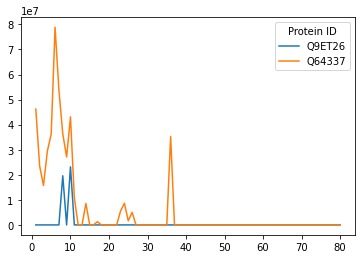

In [387]:
rnf_aPKC_p116.T.plot()

In [388]:
for uid in ['Q9ET26', 'Q64337']:
    if uid in rnf_aPKC_p116.index:
        xy = rnf_aPKC_p116.loc[[uid]]
        columns = (xy != 0).any()
        columns_list = columns.index[columns].tolist()
        
        if len(columns_list) >0:
            print('P116', uid, columns_list)

P116 Q9ET26 [8, 10]
P116 Q64337 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 23, 24, 25, 26, 36]


In [389]:
# Rnf114 - Q9ET26 in P133

In [390]:
rnf_p133 = dfp_80['P133'].loc[['Q9ET26']]
aPKC_p133 =  dfp_80['P133'].loc[['Q64337']]
TRAF6_p133 =  dfp_80['P133'].loc[['P70196']]
rnf_aPKC_p133 = pd.concat([rnf_p133, aPKC_p133, TRAF6_p133])

In [391]:
rnf_aPKC_p133

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
Protein ID,,,,,,,,,,,,,,,,,,,,,
Q9ET26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64400000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q64337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45800000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P70196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [392]:
header = []
for i in range(len(rnf_aPKC_p133.columns)):
    header.append(i+1)
rnf_aPKC_p133.columns=header


<AxesSubplot:>

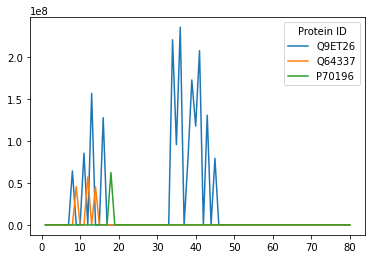

In [393]:
rnf_aPKC_p133.T.plot()

In [394]:
for uid in ['Q9ET26', 'P70196', 'Q64337']:
    if uid in rnf_aPKC_p133.index:
        xy = rnf_aPKC_p133.loc[[uid]]
        columns = (xy != 0).any()
        columns_list = columns.index[columns].tolist()
        
        if len(columns_list) >0:
            print('P133', uid, columns_list)


P133 Q9ET26 [8, 11, 13, 16, 34, 35, 36, 38, 39, 40, 41, 43, 45]
P133 P70196 [18]
P133 Q64337 [9, 12, 14]
